# Decompositions of the Multi-controlled U Gate
**Author:** Julia Cen

In this notebook, we will construct a multi-controlled U $\in$ U(2) gate that is composed of only 1-qubit gates and $CX$ gates. The definition of a multi-controlled U gate is as follows

\begin{equation}
C^{n}U |x\rangle_n |y\rangle_1=
\begin{cases}
    |x\rangle_n U|y\rangle_1,& \text{if } x= (1,1,\dots,1)\\
    |x\rangle_n |y\rangle_1,              & \text{otherwise}
\end{cases}
\end{equation}

meaning that the U gate only acts on our target qubit, $1$, only if all $n$ of our control qubits are in the $1$ state and we do nothing otheriwse. The construction presented below follows the decomposition presented in Chapter 4 of the Nielson and Chaung textbook [1].

In [1]:
from qiskit import *
from qiskit.quantum_info import *
from qiskit.circuit.library import *

import numpy as np

## Finding Phase and Euler Angles for a Given Unitary Matrix 

A given matrix U is unitary if $UU^\dagger=1$, meaning $U^\dagger=U^{-1}$. Unitary matrices have orthonomral rows and columns. The group of unitary matrices $U(N)$ is known to be the direct product of $U(1) \times SU(N)$, where $U(1)$ are all complex numbers with absolute value of 1 (the phase) and $SU(N)$ is the special unitary group with determinant 1, with $SU(2)$ being homomorphic to $SO(3)$, the group of rotations in 3D space. There are many different forms that a unitary matrix can take as we can decompose a rotation in 3D space in different ways. One common form using the ZYZ decompostion where Z,Y are the rotations about the respective axes is

\begin{equation}
U=e^{i\gamma}
\begin{pmatrix}
e^{i\phi/2} & 0\\
0 & e^{-i\phi/2}
\end{pmatrix}
\begin{pmatrix}
cos(\theta/2) & -sin(\theta/2)\\
sin(\theta/2) & cos(\theta/2)
\end{pmatrix}
\begin{pmatrix}
e^{i\lambda/2} & 0\\
0 & e^{-i\lambda/2}
\end{pmatrix}
\end{equation}

with $\phi,\theta,\lambda$ the rotation/Euler angles. Given any unitary matrix, we can the the Euler angles and phase.
<?
This is the rotation matrix form used in Qiskit's various built-in gate sets:
\begin{equation}
\begin{pmatrix}
\cos{\theta/2} & -e^{i\lambda}\sin{\theta/2}\\
e^{i\phi}\sin{\theta/2} & e^{i(\phi+\lambda)}\cos{\theta/2}.
\end{pmatrix}
\end{equation}
?>


In [2]:
# Define a 2x2 unitary matrix
unitary_input = [[0, 1],[1, 0]]

# Make unitary_input a Qiskit Operator
U = Operator(unitary_input)

# Find the Euler angles and phase (theta, phi, lambda, phase)
theta, phi, lamda, phase = OneQubitEulerDecomposer(basis='ZYZ').angles_and_phase(unitary_input)

print("Euler angles and phase of given unitary matrix are:")
print("theta =", theta)
print("phi   =", phi)
print("lambda =", lamda)
print("phase =", phase)

Euler angles and phase of given unitary matrix are:
theta = 3.141592653589793
phi   = -3.141592653589793
lambda = 0.0
phase = 1.5707963267948966


## Implementing Multi-controlled Gates with Built-in Qiskit Gates

In Qiskit there are also different ways we can directly implement the $C^{n}U$ gate in a circuit. One is using the built-in multi-controlled mutli-target gate, MCMTGate, another using ControlledGate.

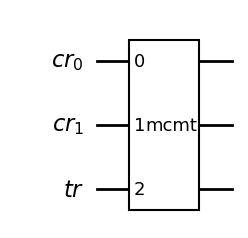

In [12]:
## MCMTGate method

# Define the number of control qubits
n=2

# Define a 2x2 unitary matrix
unitary_input = [[0, 1],[1, 0]]

# Creating the C^{n}U gate with MCMTGate in a quantum circuit

# Control register
cr = QuantumRegister(size=n, name="cr")
# Target register
tr = QuantumRegister(size=1, name="tr")

qc = QuantumCircuit(cr, tr, name="MCU")

qc.append(MCMT(gate=UnitaryGate(unitary_input), num_ctrl_qubits=n, num_target_qubits=1), range(n+1))

qc.draw(output="mpl", style="bw")


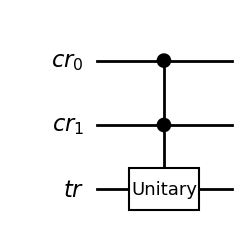

In [13]:
## ControlledGate method

# Define the number of control qubits
n=2

# Define a 2x2 unitary matrix
unitary_input = [[0, 1],[1, 0]]

# Creating the C^{n}U gate with ControlledGate in a quantum circuit

# Control register
cr = QuantumRegister(size=n, name="cr")
# Target register
tr = QuantumRegister(size=1, name="tr")

qc = QuantumCircuit(cr, tr, name="MCU")

mcu_gate = UnitaryGate(unitary_input).control(n)

qc.append(mcu_gate, qc.qubits)

qc.draw(output="mpl", style="bw")


## Nielsen and Chuang Figure 4.10

Following [1], $C^{n}U$ can be decomposed into a $C^{1}U$ gate and Toffoli gates. The idea of this decomposition is to check whether the statement that our $n$ control qubits are in the state $|11\dots 1\rangle$ is true or false. If true, then the U gate is applied to our target qubit, if not, then we don't do anything to the target qubit. This method introduces $n-1$ ancilla quibts into the circuit that are initialized all to be in the 0 state. By running through the descending Toffoli gates, the information about whether each control qubit is in the state 1 is transferred to the final ancilla qubit, which will only be 1 if all the control qubits were in the 1 state and the U gate will be applied to the target qubit. The ascending Toffoli gates are just to make sure all ancillas are returned to the initial 0 states, to keep ancillas 'clean'.

For an explicit example, let us take $n=3$, so we only apply the U gate to the target qubit $tr$ if all 3 control qubits $cr_{0,1,2}$ are 1. The first CCNOT gate turns the first ancilla, $ar_0$ to 1 only if both $cr_0$ and $cr_1$ are in the 1 state. The second CCNOT gate turns the second ancilla, $ar_1$ to 1 only if both $ar_0$ and $cr_2$, which is equivalent to all controls being 1. Then we just need a $C^{1}U$ gate to check the second ancilla; if it's 0 we don't apply U to the target qubit, if it's 1, we do.

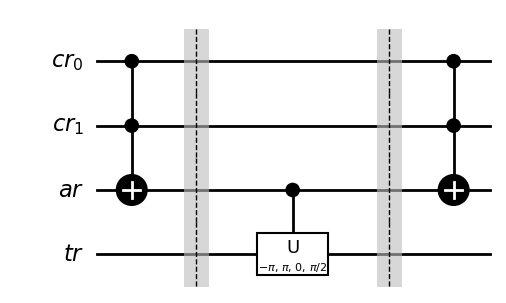

In [16]:
# Define the number of control qubits
n=2;

# Control register
cr = QuantumRegister(size=n, name="cr")
# Ancilla register
ar = AncillaRegister(size=n-1, name="ar")
# Target register
tr = QuantumRegister(size=1, name="tr")

qc = QuantumCircuit(cr, ar,tr, name="MCU")

qc.ccx(0,1,n)

for i in range(n-2):
    qc.barrier()
    qc.ccx(cr[2+i],ar[i],ar[1+i])

qc.barrier()
qc.cu(phi,theta,lam,phase,ar[n-2],tr[0])

for i in reversed(range(n-2)):
    qc.barrier()
    qc.ccx(cr[2+i],ar[i],ar[1+i])

qc.barrier()
qc.ccx(0,1,n)

qc.draw(output="mpl", style="bw")

## Decomposing the CCX and CU Gates into CX and 1-qubit Gates

The next step is to decompose our multi-controlled U $\in$ U(2) gate to 1-qubit gates and $CX$ gates only, so we look at the decomposition of CCNOT and $C^{1}U$ gates. 

In [2]:
# Toffoli gate decomposed into H,T,T^{\dagger} and CXs only

def decomposed_toffoli(c1, c2, t):
    qc.h(t)
    qc.cx(c2, t)
    qc.tdg(t) # tdg is the method for the inverse of T
    qc.cx(c1, t)
    qc.t(t)
    qc.cx(c2, t)
    qc.tdg(t)
    qc.cx(c1, t)
    qc.t(t)
    qc.h(t)
    qc.cx(c1, c2)
    qc.tdg(c2)
    qc.cx(c1, c2)
    qc.t(c1)
    qc.t(c2)

number of gates: 15
circuit depth: 12


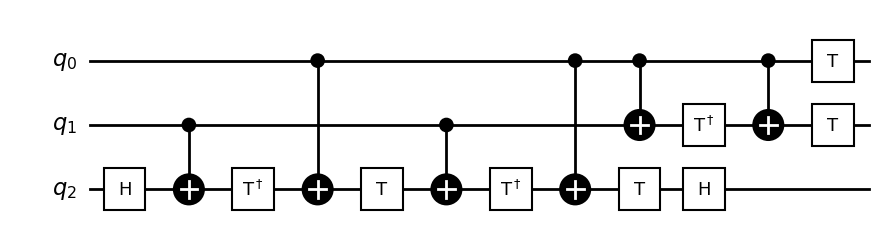

In [21]:
# The decomposed Toffoli gate

# Define the number of control qubits
n=3;

qc = QuantumCircuit(n)

decomposed_toffoli(0, 1, 2)

print("number of gates:", qc.size())
print("circuit depth:", qc.depth())
qc.draw(output="mpl", style="bw")

From [1], we saw the $U$ gate can be expressed as $e^{i\gamma}AXBXC$ where $A,B,C$ are the single qubit gates with $ABC=I$. In particular, we can take

\begin{align}
A&=R_z(\phi)R_y(\theta/2)\\
B&=R_y(-\theta/2)R_z(-(\lambda+\phi)/2)\\
C&=R_z((\lambda-\phi)/2)
\end{align}

This us a very useful decomposition. The reason is because when we create the control gate $C^1U$ using this $U$ decomposition, when the control qubit is 0, only $ABC$, which is equivalent to the identity gate, is applied to the target qubit. When the control qubit is in the 1 state,  $e^{i\gamma}$, the global phase gate, is applied to the control qubit and $AXBXC$ applied to the target qubit, which gives us the desired result.

In [3]:
# Define a 2x2 unitary matrix
unitary_input = [[0, 1],[1, 0]]

# Make unitary_input a Qiskit Operator
U = Operator(unitary_input)

# Find the Euler angles and phase (theta, phi, lambda, phase)
theta, phi, lam, phase = OneQubitEulerDecomposer(basis='ZYZ').angles_and_phase(unitary_input)

print("Euler angles and phase of given unitary matrix are:")
print("theta =", theta)
print("phi   =", phi)
print("lam =", lam)
print("phase =", phase)

# C^1U gate decomposed into CX and single qubit gates only
def decomposed_c1u(phi,theta,lam,phase,c, t):
    qc.rz((lam-phi)/2,t)
    qc.cx(c, t)
    qc.ry(-theta/2,t)
    qc.rz(-(lam+phi)/2,t)
    qc.cx(c, t)
    qc.rz(phi,t)
    qc.ry(theta/2,t)
    qc.p(phase,c)

Euler angles and phase of given unitary matrix are:
theta = 3.141592653589793
phi   = -3.141592653589793
lam = 0.0
phase = 1.5707963267948966


number of gates: 8
circuit depth: 7


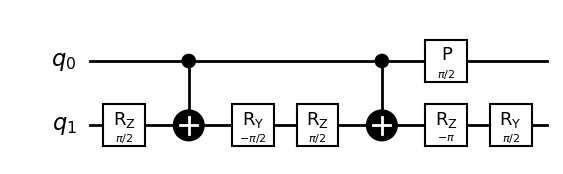

In [9]:
# The decomposed C^1U gate

# Define the number of control qubits
n=2;

qc = QuantumCircuit(n)

decomposed_c1u(phi,theta,lam,phase,0,1)

print("number of gates:", qc.size())
print("circuit depth:", qc.depth())
qc.draw(output="mpl", style="bw")

## Multi-controlled U Gate Decomposed into CX and 1-qubit Gates

Now we can combine everything together to obtain a fully decomposed $C^nU$ gate in terms of CNOTs and 1-qubit gates only. We print the gate with and without barriers.

Euler angles and phase of given unitary matrix are:
theta = 3.141592653589793
phi   = -3.141592653589793
lam = 0.0
phase = 1.5707963267948966
number of gates: 38
circuit depth: 31


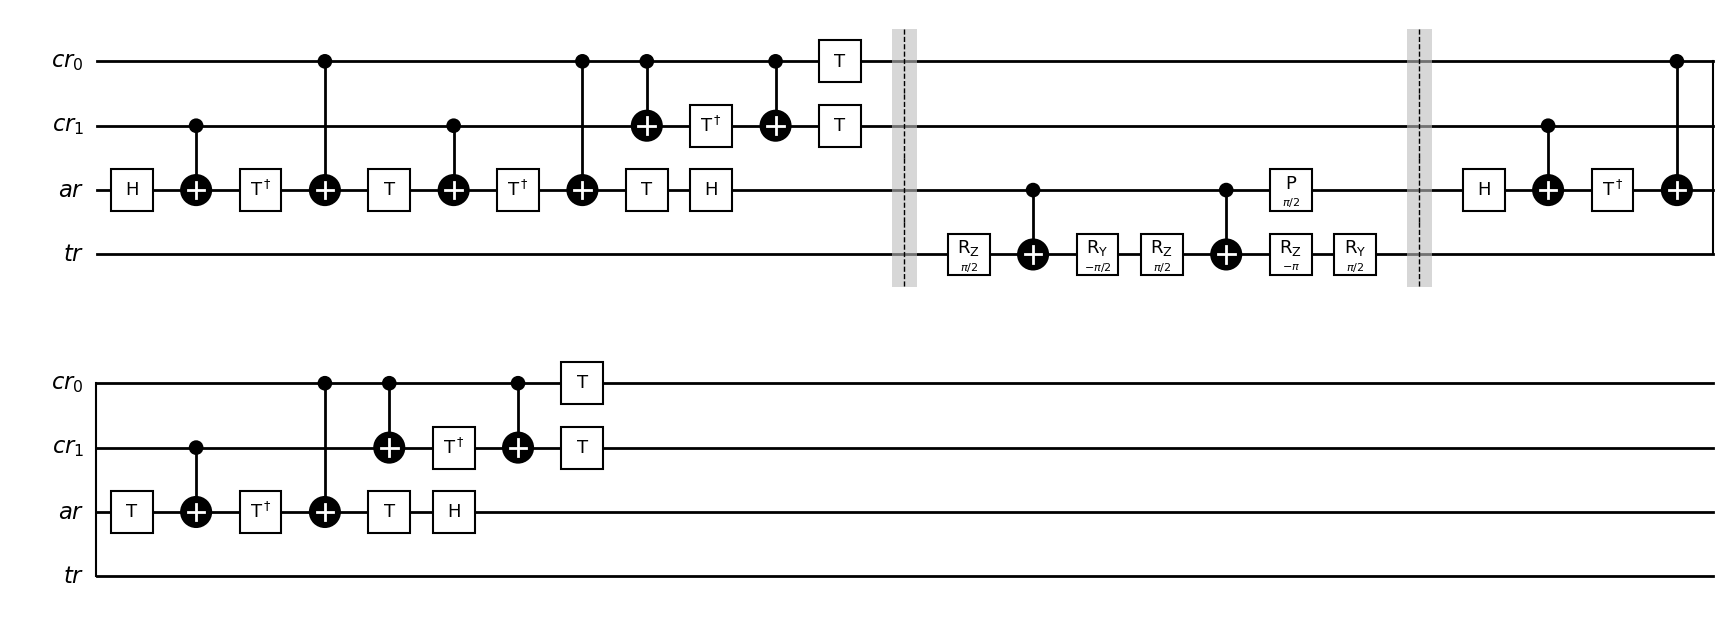

In [7]:
# Define the number of control qubits
n=2;

# Define a 2x2 unitary matrix
unitary_input = [[0, 1],[1, 0]]

# Make unitary_input a Qiskit Operator
U = Operator(unitary_input)

# Find the Euler angles and phase (theta, phi, lambda, phase)
theta, phi, lam, phase = OneQubitEulerDecomposer(basis='ZYZ').angles_and_phase(unitary_input)

print("Euler angles and phase of given unitary matrix are:")
print("theta =", theta)
print("phi   =", phi)
print("lam =", lam)
print("phase =", phase)

# Control register
cr = QuantumRegister(size=n, name="cr")
# Ancilla register
ar = AncillaRegister(size=n-1, name="ar")
# Target register
tr = QuantumRegister(size=1, name="tr")

qc = QuantumCircuit(cr, ar,tr, name="MCU")

decomposed_toffoli(0,1,n)

for i in range(n-2):
    qc.barrier()
    decomposed_toffoli(cr[2+i],ar[i],ar[1+i])

qc.barrier()
decomposed_c1u(phi,theta,lam,phase,ar[n-2],tr[0])

for i in reversed(range(n-2)):
    qc.barrier()
    decomposed_toffoli(cr[2+i],ar[i],ar[1+i])

qc.barrier()
decomposed_toffoli(0,1,n)

print("number of gates:", qc.size())
print("circuit depth:", qc.depth())
qc.draw(output="mpl", style="bw")

The circuit without barriers to obtain true circuit depth.

Euler angles and phase of given unitary matrix are:
theta = 3.141592653589793
phi   = -3.141592653589793
lam = 0.0
phase = 1.5707963267948966
number of gates: 38
circuit depth: 27


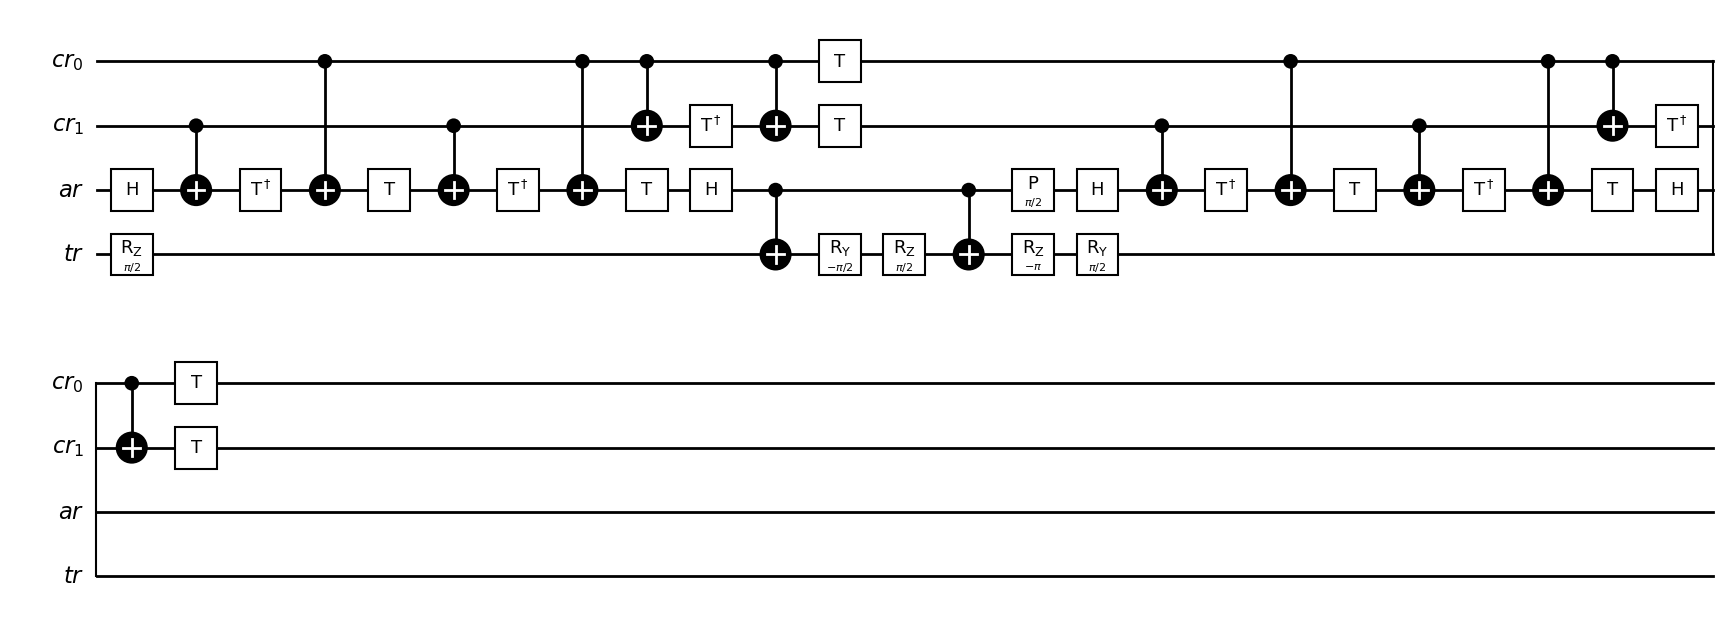

In [19]:
# Define the number of control qubits
n=2;

# Define a 2x2 unitary matrix
unitary_input = [[0, 1],[1, 0]]

# Make unitary_input a Qiskit Operator
U = Operator(unitary_input)

# Find the Euler angles and phase (theta, phi, lambda, phase)
theta, phi, lam, phase = OneQubitEulerDecomposer(basis='ZYZ').angles_and_phase(unitary_input)

print("Euler angles and phase of given unitary matrix are:")
print("theta =", theta)
print("phi   =", phi)
print("lam =", lam)
print("phase =", phase)

# Control register
cr = QuantumRegister(size=n, name="cr")
# Ancilla register
ar = AncillaRegister(size=n-1, name="ar")
# Target register
tr = QuantumRegister(size=1, name="tr")

qc = QuantumCircuit(cr, ar,tr, name="MCU")

decomposed_toffoli(0,1,n)

for i in range(n-2):
    decomposed_toffoli(cr[2+i],ar[i],ar[1+i])

decomposed_c1u(phi,theta,lam,phase,ar[n-2],tr[0])

for i in reversed(range(n-2)):
    decomposed_toffoli(cr[2+i],ar[i],ar[1+i])

decomposed_toffoli(0,1,n)

print("number of gates:", qc.size())
print("circuit depth:", qc.depth())
qc.draw(output="mpl", style="bw")


# Benchmarking

In this section, we test that our decomposition of a multi-controlled U gate matches with the definition, which means for a given n, the U gate is only applied to the target bit if all controls are in the 1 state.

In [9]:
# Define the number of control qubits
n = 2

bits0=[]
bits1=[]

# Create list of all possible bitstrings (ancillas kept 0)
for i in range(2 ** n):
    # target qubit in the 0 state
    bits0.append(bin(i)[2:].zfill(n)+'0'*n)
    # target qubit in the 1 state
    bits1.append(bin(i)[2:].zfill(n)+'0'*(n-1)+'1')

bits = bits0 + bits1
print(bits)

['0000', '0100', '1000', '1100', '0001', '0101', '1001', '1101']


Let us test the case when $n=2$ and U is the XGATE, then our target qubit state should change from $0,1$ to $1,0$ only if both our controls are in the 1 state. 

In [20]:
# run the quantum circuit through all bitstrings
for i in range(2*2 ** n):
    # we reverse bitstring order following Qiskit's convention, so the order is |tr,ar,cr> ([::-1] reverses string)
    input_state = Statevector.from_label(bits[i][::-1])
    output_state = input_state.evolve(qc)
    
    print("Input", "|", bits[i][::-1], ">")
    display(output_state.draw(output="Latex"))

Input | 0000 >


<IPython.core.display.Latex object>

Input | 0010 >


<IPython.core.display.Latex object>

Input | 0001 >


<IPython.core.display.Latex object>

Input | 0011 >


<IPython.core.display.Latex object>

Input | 1000 >


<IPython.core.display.Latex object>

Input | 1010 >


<IPython.core.display.Latex object>

Input | 1001 >


<IPython.core.display.Latex object>

Input | 1011 >


<IPython.core.display.Latex object>

# Complexities and Resources

Here we analyze the cost of implementing the $C^nU$ gate via the decomposition presented in this notebook. 

| no. controls (n) | no. ancillas | total qubits | no. Toffolis | no. single gates | no. cnots | no. single & cnots | gate depth |
|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|
|  0   |  0   |  1   |  0   |  1   |  0   |  1   |  1   |
|  1   |  0   |  2   |  0   |  6   |  2   |  8   |  7   |
|  2   |  1   |  4   |  2   |  24   |  14   |  38   |  27   |
|  3   |  2   |  6   |  4   |  42   |  26   |  68   |  48   |
|  4   |  3   |  8   |  6   |  60   |  38   |  98   |  69   |
|  5   |  4   |  10  |  8   |  78   |  50   | 128    |  90   |

In general for $n\geq 2$, we have

| no. controls (n) | no. ancillas | total qubits | no. Toffolis | no. single gates | no. cnots | no. single & cnots | gate depth |
|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|
|  n   |  n-1 |  2n  |  2(n-1)   |  18n-12   |  12n-10   |  30n-22   |  21n-15   |

As $n\rightarrow\infty$, using the big-O notation we have  

| no. controls (n) | no. ancillas | total qubits | no. Toffolis | no. single gates | no. cnots | no. single & cnots | gate depth |
|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|
|  O($n$)  |  O($n$)  |  O($n$)  |  O($n$)  |  O($n$)  |  O($n$)  |  O($n$)  |  O($n$)  |

The gate count and depth shown above is the upper bound. With more familarity with special gate patterns, some sort of optimization may be done to reduce these numbers. Another idea is to look at runtime and noise implementing this decomposition on real hardware and compare with Qiskit's built in gates. 

# Other Decomposition Methods

I am currently reading [2] and trying to understand how the grey code can be implemented in a quantum circuit for further optimization on the construction of MCU gates.

# References

[1] Nielsen, M. & Chuang, I., Quantum Computation and Quantum Information: 10th Anniversary Edition, Cambridge University Press, (2011).

[2] Barenco, A., Bennett, C.H., Cleve, R., DiVincenzo, D.P., Margolus, N., Shor, P., Sleator, T., Smolin, J.A. and Weinfurter, H., Elementary gates for quantum computation, Physical review A, 52(5), p.3457, (1995).

[3] Da Silva, A.J. and Park, D.K., Linear-depth quantum circuits for multiqubit controlled gates, Physical Review A, 106(4), p.042602, (2022).